Plots win rate throughout training.

In [1]:
from typing import Iterable, List, Mapping, Optional, Tuple

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

import utils

plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("1-col")]
)

In [2]:
def plot_training(
    df: pd.DataFrame,
    victim_name_to_plot_label: Mapping[str, str],
    highlighted_point_step: int,
    victim_change_steps: Iterable[int],
    board_size: int = 19,
    ignored_adversaries: Optional[List] = None,
    legend_ncol: Optional[int] = None,
) -> Tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    """Plot win rate throughout training.

    Params:
        df: Data
        victim_name_to_plot_label: Key = victims to plot, value = label on plot legend
        highlighted_point_step: Point (specified by adversary training steps) to mark
          with a special marker on the plot
        victim_changes_steps: Training steps at which the victim changed
        plot_name: Filename of plot
        ignored_adversaries: Names of adversaries to ignore due to bad data
        legend_ncol: Override the number of legend_columns
    """
    if ignored_adversaries is None:
        ignored_adversaries = []

    df = df.loc[df.board_size == board_size]
    for adv in ignored_adversaries:
        df = df.loc[df.adv_name != adv]

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, axs = plt.subplots(1, 1)

    ALPHA = 0.05
    df["adv_win_perc"] = df.adv_win * 100
    for i, (victim_name, victim_label) in enumerate(victim_name_to_plot_label.items()):
        victim_df = df[df.victim_name == victim_name]
        mean_df = victim_df.groupby("adv_steps").mean(True)
        ax = mean_df.adv_win_perc.plot(label=victim_label)
        conf_df = mean_df.apply(
            lambda x: proportion_confint(
                len(victim_df[(victim_df.adv_steps == x.name) & (victim_df.adv_win)]),
                len(victim_df[victim_df.adv_steps == int(x.name)]),
                alpha=ALPHA,
                # Generate Clopper-Pearson confidence intervals:
                # https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html
                method="beta",
            ),
            axis=1,
            result_type="expand",
        )
        plt.fill_between(mean_df.index, conf_df[0] * 100, conf_df[1] * 100, alpha=0.3)
        plt.plot(
            highlighted_point_step,
            mean_df.adv_win_perc.loc[highlighted_point_step].item(),
            "D",
            color=colors[i],
        )

    max_step = df.adv_steps.max()
    for xc in victim_change_steps:
        if xc > 0 and xc < max_step:
            plt.axvline(x=xc, linestyle=":", linewidth=1, color=colors[3])

    if legend_ncol is None:
        legend_ncol = len(victim_name_to_plot_label)
    plt.ylabel(r"Adversary win rate \%")
    plt.xlabel("Adversary training steps")
    plt.margins(x=0)
    plt.legend(
        loc="lower center", bbox_to_anchor=(0.5, 1.0), ncols=legend_ncol, fancybox=True
    )
    _, x_max = plt.xlim()
    plt.xlim(right=max(x_max, 1.02 * highlighted_point_step))

    return fig, axs

Victim change steps: [0, 0, 12560640, 16541696, 22263040, 25102336]
All victims: ['cp127-v1' 'cp505-v1' 'cp505h-v1']


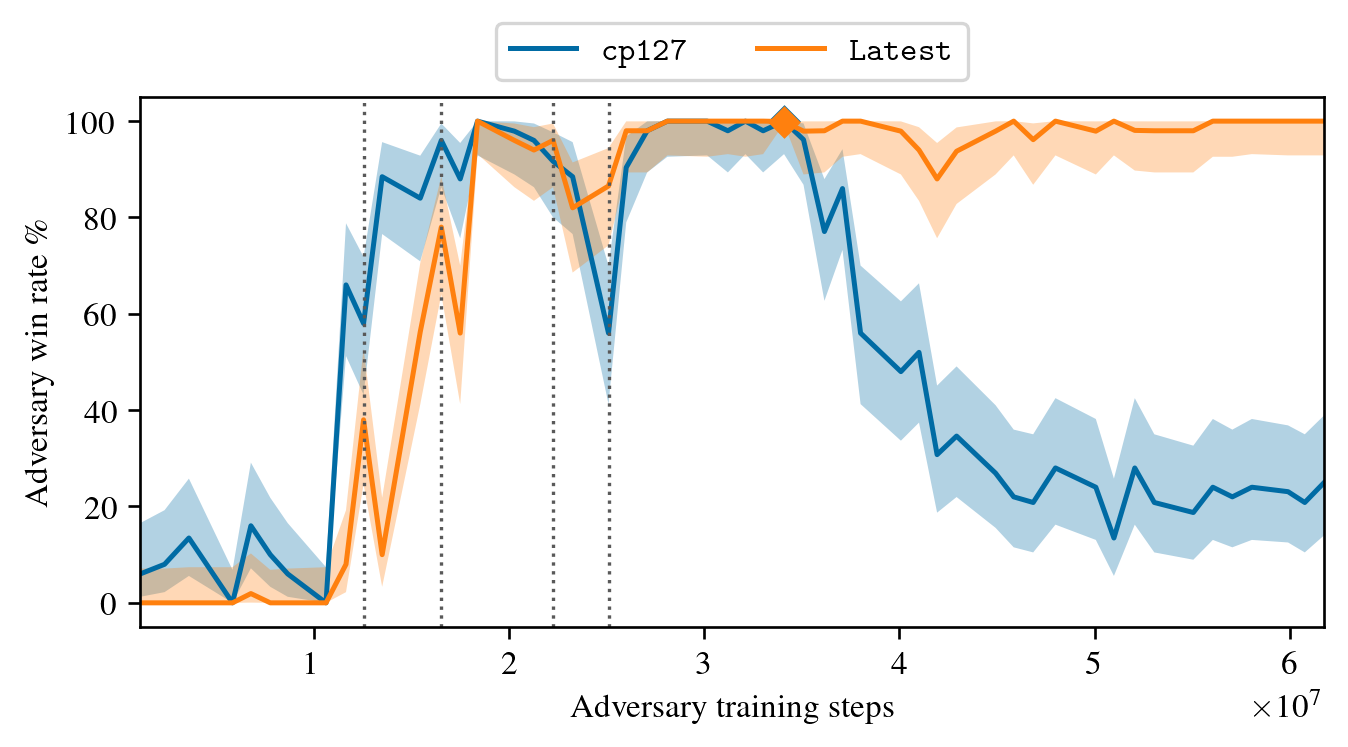

In [3]:
training_df = utils.parse_sgfs(
    ["/nas/ucb/tony/go-attack/training/emcts1-curr/cp127-to-505-v1/selfplay"]
)
victim_change_steps = utils.get_victim_change_steps(training_df)
print("Victim change steps:", victim_change_steps)

df = utils.parse_sgfs(
    [
        "/nas/ucb/k8/go-attack/match/ttseng-unhardened-paper-eval-221130/training-checkpoint-sweep"
    ]
)

print("All victims:", df.victim_name.unique())
victim_name_to_plot_label = {
    "cp127-v1": r"\texttt{cp127}",
    "cp505-v1": r"\texttt{Latest}",
}
fig, _ = plot_training(
    df,
    victim_name_to_plot_label,
    34090496,
    victim_change_steps,
)
fig.savefig("adv-training.pgf", backend="pgf")

Victim change steps: [0, 30365184, 34502144, 38566400, 87698176, 164908288, 194422784, 198203136, 205049600, 212038912, 218883584, 227013120, 227013120, 230932992, 417232384, 466991360, 486887168, 491808000, 495654912, 499575296, 503639552, 509699584, 516545024, 522673664, 529022720, 534938880, 539786240, 544065792]
All victims: ['cp505h-v2048' 'cp127h-v1' 'cp39h-v1' 'cp505h-v1' 'cp505-v1'
 'cp505-v2048']


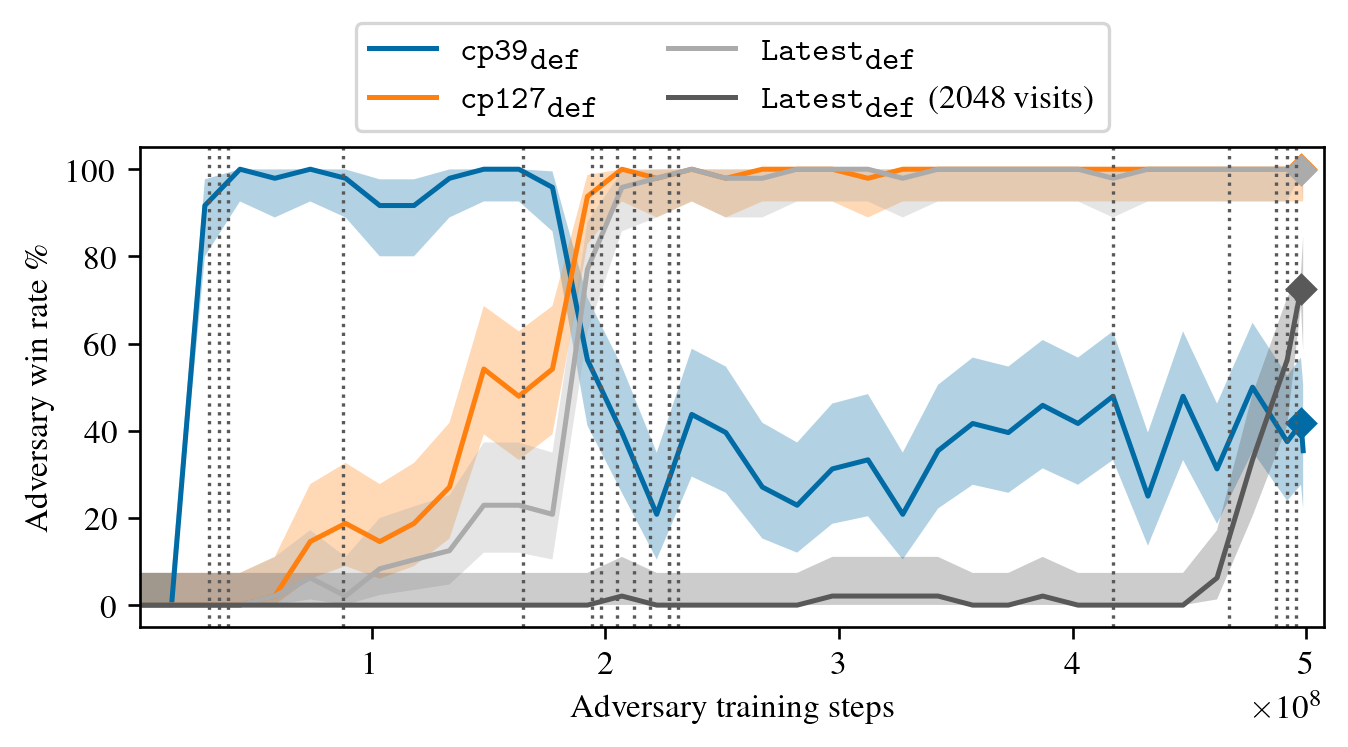

In [4]:
training_df = utils.parse_sgfs(
    [
        "/nas/ucb/k8/go-attack/victimplay/ttseng-avoid-pass-alive-coldstart-39-20221025-175949/selfplay"
    ]
)
victim_change_steps = utils.get_victim_change_steps(training_df)
print("Victim change steps:", victim_change_steps)

df = utils.parse_sgfs(
    ["/nas/ucb/k8/go-attack/match/ttseng-hard-adv-checkpoint-sweep-497mil-221115"]
)
print("All victims:", df.victim_name.unique())
victim_name_to_plot_label = {
    "cp39h-v1": r"$\texttt{cp39}_\texttt{def}$",
    "cp127h-v1": r"$\texttt{cp127}_\texttt{def}$",
    "cp505h-v1": r"$\texttt{Latest}_\texttt{def}$",
    "cp505h-v2048": r"$\texttt{Latest}_\texttt{def}$ (2048 visits)",
}
fig, _ = plot_training(
    df,
    victim_name_to_plot_label,
    497721856,
    victim_change_steps,
    legend_ncol=2,
)
fig.savefig("adv-497mil-training-hardened.pgf", backend="pgf")